### Example 1: 2 node system

#### Importing packages

In [32]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cartopy as ccrs
plt.style.use('bmh')
import os

#### Step 1:Fuel & Powerplant data(Costs, efficiency)

In [33]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])
#costs = pd.read_csv("..\data\costs.csv")#, index_col=[0,1])

In [34]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

In [35]:
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

In [36]:
costs = costs.value.unstack().fillna(defaults)

In [37]:
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

In [38]:
costs = costs.fillna(defaults)

In [39]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [40]:
costs.head(2)

parameter,C in fuel,C stored,CO2 intensity,CO2 stored,FOM,VOM,ammonia-input,c_b,c_v,capacity,...,hydrogen-input,investment,lifetime,lohc-input,methane-input,methanol-input,min_fill_level,nitrogen-input,p_nom_ratio,pelletizing cost
technology,,,,,,,,,,,,,,,,,,,,,
Ammonia cracker,NaN,NaN,0.0,NaN,4.30,0.0,1.46,NaN,NaN,NaN,...,NaN,1062107.74,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BioSNG,0.34,0.66,0.0,0.24,1.64,1.7,NaN,NaN,NaN,NaN,...,NaN,1600000.00,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

In [42]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [43]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

#### Loading time series data

In [67]:
os.chdir("c:\\Users\\par19744\\Python_projects")

In [68]:
os.getcwd()

'c:\\Users\\par19744\\Python_projects'

In [69]:
#url = "https://tubcloud.tu-berlin.de/s/pKttFadrbTKSJKF/download/time-series-lecture-2.csv"
ts = pd.read_csv("timeseries.csv", index_col=0, parse_dates=True)

In [70]:
ts

,load,onwind,offwind,solar,prices
2015-01-01 00:00:00,41.151,0.1566,0.7030,0.0,NaN
2015-01-01 01:00:00,40.135,0.1659,0.6875,0.0,NaN
2015-01-01 02:00:00,39.106,0.1746,0.6535,0.0,NaN
2015-01-01 03:00:00,38.765,0.1745,0.6803,0.0,NaN
2015-01-01 04:00:00,38.941,0.1826,0.7272,0.0,NaN
...,...,...,...,...,...
2015-12-31 19:00:00,47.719,0.1388,0.4434,0.0,36.79
2015-12-31 20:00:00,45.911,0.1211,0.4023,0.0,28.81
2015-12-31 21:00:00,45.611,0.1082,0.4171,0.0,26.27
2015-12-31 22:00:00,43.762,0.1026,0.4716,0.0,29.99


In [71]:
resolution = 4
ts = ts.resample(f"{resolution}H").first()

In [86]:
ts['onwind']

2015-01-01 00:00:00    0.1566
2015-01-01 04:00:00    0.1826
2015-01-01 08:00:00    0.2281
2015-01-01 12:00:00    0.2384
2015-01-01 16:00:00    0.3828
                        ...  
2015-12-31 04:00:00    0.4099
2015-12-31 08:00:00    0.3269
2015-12-31 12:00:00    0.2319
2015-12-31 16:00:00    0.1942
2015-12-31 20:00:00    0.1211
Freq: 4H, Name: onwind, Length: 2190, dtype: float64

#### Step 2: Model Initialization

In [73]:
# A) Create a network object
n=pypsa.Network()

In [74]:
# B) Add buses
n.add("Bus", "electricity")
#n.add("Bus", "Ambon_1", y=13.4, x=52.5, v_nom=400, carrier='AC')#Ambon_1
#n.add("Bus", "Ambon_2", y=14.3, x=51.7, v_nom=400, carrier='AC') #Ambon_2

In [75]:
# C) Add snapshots to the network
n.set_snapshots(ts.index)

In [76]:
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 04:00:00',
               '2015-01-01 08:00:00', '2015-01-01 12:00:00',
               '2015-01-01 16:00:00', '2015-01-01 20:00:00',
               '2015-01-02 00:00:00', '2015-01-02 04:00:00',
               '2015-01-02 08:00:00', '2015-01-02 12:00:00',
               ...
               '2015-12-30 08:00:00', '2015-12-30 12:00:00',
               '2015-12-30 16:00:00', '2015-12-30 20:00:00',
               '2015-12-31 00:00:00', '2015-12-31 04:00:00',
               '2015-12-31 08:00:00', '2015-12-31 12:00:00',
               '2015-12-31 16:00:00', '2015-12-31 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2190, freq='4H')

In [77]:
n.snapshot_weightings.head(10)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,1.0,1.0,1.0
2015-01-01 04:00:00,1.0,1.0,1.0
2015-01-01 08:00:00,1.0,1.0,1.0
2015-01-01 12:00:00,1.0,1.0,1.0
2015-01-01 16:00:00,1.0,1.0,1.0
2015-01-01 20:00:00,1.0,1.0,1.0
2015-01-02 00:00:00,1.0,1.0,1.0
2015-01-02 04:00:00,1.0,1.0,1.0
2015-01-02 08:00:00,1.0,1.0,1.0


In [78]:
n.snapshot_weightings.loc[:,:] = resolution

In [79]:
n.snapshot_weightings.head(10)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,4.0,4.0,4.0
2015-01-01 04:00:00,4.0,4.0,4.0
2015-01-01 08:00:00,4.0,4.0,4.0
2015-01-01 12:00:00,4.0,4.0,4.0
2015-01-01 16:00:00,4.0,4.0,4.0
2015-01-01 20:00:00,4.0,4.0,4.0
2015-01-02 00:00:00,4.0,4.0,4.0
2015-01-02 04:00:00,4.0,4.0,4.0
2015-01-02 08:00:00,4.0,4.0,4.0


In [80]:
# D) Add carriers with emissions associated with it
carriers = ["onwind", "offwind", "solar", "OCGT", "hydrogen storage underground", "battery storage"]
n.madd(
    "Carrier",
    carriers, 
    color=["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers]
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'hydrogen storage underground',
       'battery storage'],
      dtype='object')

In [81]:
# E) Add demand time series
n.add(
    "Load",
    "demand",
    bus="electricity",
    p_set=ts.load,
)

<AxesSubplot:xlabel='snapshot', ylabel='MW'>

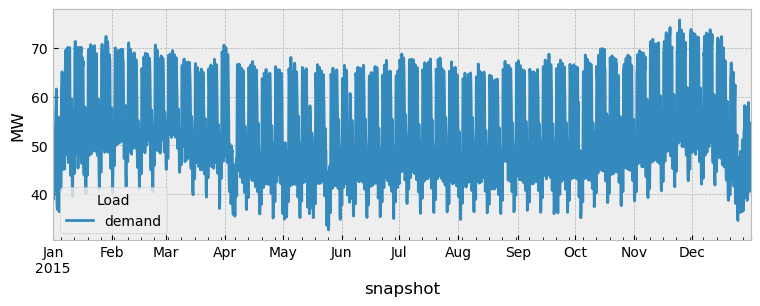

In [82]:
n.loads_t.p_set.plot(figsize=(9,3), ylabel="MW")

In [83]:
# F) Add generators #dispatchable
n.add(
    "Generator",
    "OCGT",
    bus='electricity',
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

In [84]:
# G) Add generators Renewable
for tech in ["onwind", "offwind", "solar"]:
    n.add(
        "Generator",
        tech,
        bus='electricity',
        carrier=tech,
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,
    )

<AxesSubplot:xlabel='snapshot', ylabel='CF'>

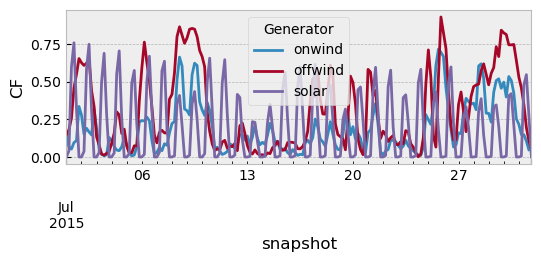

In [116]:
n.generators_t.p_max_pu.loc["2015-07"].plot(figsize=(6,2), ylabel="CF")

#### Step 3) Run the model and print the optimization results

##### A) Solve the model

In [117]:
n.lopf(solver_name='glpk')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.22s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+07


('ok', 'optimal')

##### B) Optimized capacity (GW) & Energy generation(TWh)

In [118]:
# Optimized capacity in GW
n.generators.p_nom_opt.div(1e3)

Generator
OCGT       0.070182
onwind     0.000000
offwind    0.042400
solar      0.082323
Name: p_nom_opt, dtype: float64

In [119]:
# The total energy generation by technology in GW:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6) # TWh

Generator
OCGT       0.258400
onwind     0.000000
offwind    0.131445
solar      0.089080
Name: generators, dtype: float64

##### C) Print various Costs ( Total, capex, opex)

In [120]:
# The total system cost in billion Euros per year:
n.objective / 1e9

0.02753228923

In [121]:
# Costs M€/a
opex = n.snapshot_weightings.generators @ (n.generators_t.p * n.generators.marginal_cost).div(1e6) # M€/a
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6) # M€/a
print(capex, opex) # M€/a

Generator
OCGT       3.164897
onwind     0.000000
offwind    6.704369
solar      3.828770
dtype: float64 Generator
OCGT       13.830724
onwind      0.000000
offwind     0.002629
solar       0.000891
Name: generators, dtype: float64


In [122]:
#Total system cost by technology M€/a
(n.statistics.capex() + n.statistics.opex(aggregate_time='sum')).div(1e6)

           carrier
Generator  OCGT       16.995622
           offwind     6.706998
           onwind      0.000000
           solar       3.829661
dtype: float64

##

##### D) Emissions (t/h)

In [123]:
emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

In [124]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

0.12604898053502442

#### E) Plotting optimal dispatch

This function takes the network object `n` as an argument and, optionally, a time frame. We want to plot the load time series, and stacked area charts for electricity feed-in and storage charging. Technologies should be coloured by their color defined in `n.carriers`.

In [125]:
def plot_dispatch(n, time="2015-07"):
    
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    
    fig, ax = plt.subplots(figsize=(6, 3))
    
    color = p_by_carrier.columns.map(n.carriers.color)
    
    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')

    plt.legend(loc=(1.05,0))
    ax.set_ylabel("GW")
    ax.set_ylim(-200, 200)

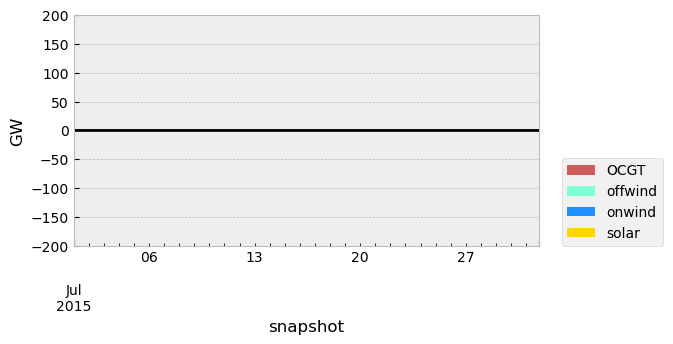

In [126]:
plot_dispatch(n)

#### F) Add Storage units ( Battery(Energy-to-power ratio:6 hours), Hydrogen) 

In [127]:
n.add(
    "StorageUnit",
    "battery storage",
    bus='electricity',
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Second, the hydrogen storage. This one is composed of an electrolysis to convert electricity to hydrogen, a fuel cell to re-convert hydrogen to electricity and underground storage (e.g. in salt caverns). We assume an energy-to-power ratio of 168 hours, such that this type of storage can be used for weekly balancing.

In [ ]:
n.plot(bus_sizes=0.01, margin=3);

In [ ]:
n.generators_t.p

In [ ]:
n.buses_t.marginal_price

In [ ]:
s = n.loads.groupby('bus').p_set.sum() / 1e4

In [ ]:
n.generators_t.p.loc["now"]

In [ ]:
n.generators.groupby("carrier").p_nom.sum().div(1e3).plot.bar()
plt.ylabel('GW')